<a href="https://colab.research.google.com/github/Guenole-tech/Lorentz-IA/blob/main/lorentz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers geoopt pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 4.0 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import AutoTokenizer, AutoModel
import geoopt

# ---------------------------
# 1. ESPACE LORENTZIEN
# ---------------------------

manifold = geoopt.manifolds.Lorentz()

def lorentz_normalize(x):
    return manifold.projx(x)

# ---------------------------
# 2. ENCODER TEXTE (NLP)
# ---------------------------

class HyperbolicTextEncoder(nn.Module):
    def __init__(self, dim=32):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        self.model = AutoModel.from_pretrained("distilbert-base-uncased")

        self.proj = nn.Linear(768, dim)

    def forward(self, text):
        tokens = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        out = self.model(**tokens).last_hidden_state[:,0]  # CLS token

        x = self.proj(out)
        x = lorentz_normalize(x)
        return x


# ---------------------------
# 3. ENCODER IMAGE (VISION)
# ---------------------------

class HyperbolicImageEncoder(nn.Module):
    def __init__(self, dim=32):
        super().__init__()

        cnn = models.resnet18(pretrained=True)
        cnn.fc = nn.Identity()  # remove classifier
        self.cnn = cnn

        self.proj = nn.Linear(512, dim)

    def forward(self, img):
        feat = self.cnn(img)
        x = self.proj(feat)
        x = lorentz_normalize(x)
        return x


# ---------------------------
# 4. MODELE MULTIMODAL
# ---------------------------

class HyperbolicMultimodal(nn.Module):
    def __init__(self, dim=32):
        super().__init__()
        self.txt = HyperbolicTextEncoder(dim)
        self.img = HyperbolicImageEncoder(dim)

    def lorentz_distance(self, u, v):
        return manifold.dist(u, v)

    def forward(self, image, text):
        z_img = self.img(image)
        z_txt = self.txt(text)
        d = self.lorentz_distance(z_img, z_txt)
        return d, z_img, z_txt


# ---------------------------
# 5. UTILISATION
# ---------------------------

model = HyperbolicMultimodal(dim=16)

# Exemple d’image (batch)
dummy_image = torch.randn(1, 3, 224, 224)  # remplace par une vraie image
dummy_text = ["a black cat sitting on a chair"]

distance, img_emb, txt_emb = model(dummy_image, dummy_text)

print("Distance hyperbolique image ↔ texte :", distance.item())
print("Embedding image :", img_emb)
print("Embedding texte :", txt_emb)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 121MB/s]


Distance hyperbolique image ↔ texte : 1.67743980884552
Embedding image : tensor([[ 1.9792, -0.0287,  0.0932, -0.3972, -0.3485,  0.5205,  0.1910, -1.0919,
         -0.0887,  0.4069,  0.4310, -0.7128,  0.1510, -0.4071,  0.1670, -0.2128]],
       grad_fn=<CatBackward0>)
Embedding texte : tensor([[ 1.3191, -0.3819, -0.1131, -0.2227, -0.1271,  0.3167, -0.0356,  0.0774,
         -0.2370, -0.1863, -0.5175,  0.1480, -0.0794, -0.0190, -0.0418, -0.1382]],
       grad_fn=<CatBackward0>)


In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import AutoTokenizer, AutoModel
import geoopt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from PIL import Image
import os


In [5]:
# Texte
texts = [
    "A small black cat",
    "A red car on the road",
    "A plate of delicious food"
]

# Images factices (remplace par tes propres images si tu veux)
images = torch.randn(3, 3, 224, 224)  # 3 images aléatoires


In [6]:
# --- Hyperbolique (Lorentz) ---
manifold = geoopt.manifolds.Lorentz()
def lorentz_normalize(x):
    return manifold.projx(x)

class HyperbolicTextEncoder(nn.Module):
    def __init__(self, dim=16):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        self.model = AutoModel.from_pretrained("distilbert-base-uncased")
        self.proj = nn.Linear(768, dim)
    def forward(self, text):
        tokens = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        out = self.model(**tokens).last_hidden_state[:,0]
        return lorentz_normalize(self.proj(out))

class HyperbolicImageEncoder(nn.Module):
    def __init__(self, dim=16):
        super().__init__()
        cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        cnn.fc = nn.Identity()
        self.cnn = cnn
        self.proj = nn.Linear(512, dim)
    def forward(self, img):
        feat = self.cnn(img)
        return lorentz_normalize(self.proj(feat))

# --- Euclidien (baseline) ---
class EuclideanTextEncoder(HyperbolicTextEncoder):
    def forward(self, text):
        tokens = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        out = self.model(**tokens).last_hidden_state[:,0]
        return self.proj(out)  # pas de normalisation Lorentz

class EuclideanImageEncoder(HyperbolicImageEncoder):
    def forward(self, img):
        feat = self.cnn(img)
        return self.proj(feat)  # pas de normalisation Lorentz


In [7]:
# Instancier modèles
hyp_txt_enc = HyperbolicTextEncoder()
hyp_img_enc = HyperbolicImageEncoder()
euc_txt_enc = EuclideanTextEncoder()
euc_img_enc = EuclideanImageEncoder()

# Hyperbolique embeddings
hyp_txt_embs = torch.cat([hyp_txt_enc([t]) for t in texts], dim=0)
hyp_img_embs = hyp_img_enc(images)

# Euclidien embeddings
euc_txt_embs = torch.cat([euc_txt_enc([t]) for t in texts], dim=0)
euc_img_embs = euc_img_enc(images)


In [8]:
# Hyperbolique distances
hyp_dist = torch.cdist(hyp_txt_embs, hyp_img_embs)  # approximatif
hyp_pred = hyp_dist.argmin(dim=1)
hyp_recall1 = (hyp_pred == torch.arange(len(texts))).float().mean()
print("Hyperbolique Recall@1 :", hyp_recall1.item())

# Euclidien distances
euc_dist = torch.cdist(euc_txt_embs, euc_img_embs)
euc_pred = euc_dist.argmin(dim=1)
euc_recall1 = (euc_pred == torch.arange(len(texts))).float().mean()
print("Euclidien Recall@1 :", euc_recall1.item())


Hyperbolique Recall@1 : 0.3333333432674408
Euclidien Recall@1 : 0.3333333432674408


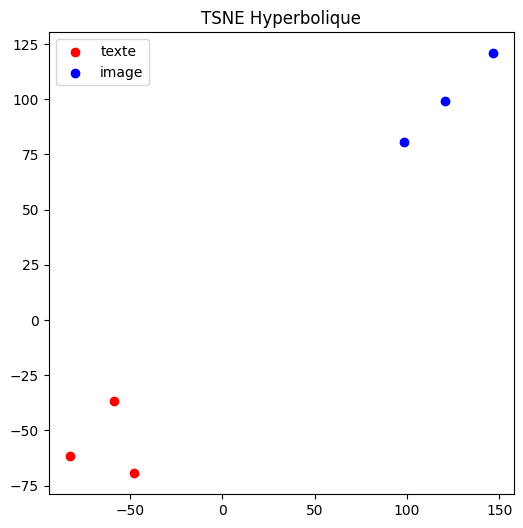

ValueError: perplexity must be less than n_samples

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Hyperbolique embeddings
tsne = TSNE(n_components=2, perplexity=2, random_state=42)
hyp_emb_2d = tsne.fit_transform(torch.cat([hyp_txt_embs, hyp_img_embs], dim=0).detach().numpy())

plt.figure(figsize=(6,6))
plt.scatter(hyp_emb_2d[:3,0], hyp_emb_2d[:3,1], c='r', label='texte')
plt.scatter(hyp_emb_2d[3:,0], hyp_emb_2d[3:,1], c='b', label='image')
plt.title("TSNE Hyperbolique")
plt.legend()
plt.show()
tsne = TSNE(n_components=2, random_state=42)

# Hyperbolique
hyp_emb_2d = tsne.fit_transform(torch.cat([hyp_txt_embs, hyp_img_embs], dim=0).detach().numpy())
plt.figure(figsize=(6,6))
plt.scatter(hyp_emb_2d[:3,0], hyp_emb_2d[:3,1], c='r', label='texte')
plt.scatter(hyp_emb_2d[3:,0], hyp_emb_2d[3:,1], c='b', label='image')
plt.title("TSNE Hyperbolique")
plt.legend()
plt.show()

# Euclidien
euc_emb_2d = tsne.fit_transform(torch.cat([euc_txt_embs, euc_img_embs], dim=0).detach().numpy())
plt.figure(figsize=(6,6))
plt.scatter(euc_emb_2d[:3,0], euc_emb_2d[:3,1], c='r', label='texte')
plt.scatter(euc_emb_2d[3:,0], euc_emb_2d[3:,1], c='b', label='image')
plt.title("TSNE Euclidien")
plt.legend()
plt.show()
